In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Functions for loading in qmc, vmc, and exact data (vmc and exact are together in one function)

In [ ]:
def load_qmc_energy_data(data_dir, D="1D", L=12, N=12, M=12, l=2, t="1.0000", beta="1.0000", seed="2001", trialstate="constant"):
    """
    Load QMC kinetic and potential energy data, and compute total energy if both components are present.
    """
    import os
    import re
    import pandas as pd

    tag = f"{D}_L{L}_N{N}_M{M}_l{l}"
    pattern = re.compile(
        rf"(K|V)_{tag}_U([0-9.]+)_t{t}_beta{beta}_binsize10000_seed{seed}_square_trialstate_{trialstate}\.dat"
    )

    energy_data = {}

    for fname in os.listdir(data_dir):
        match = pattern.match(fname)
        if match:
            kind = match.group(1)
            U_val = float(match.group(2))
            fpath = os.path.join(data_dir, fname)
            # print(f"✔ Found file for U={U_val:.1f}, type={kind}: {fname}")  # Debug print

            df = pd.read_csv(fpath, delim_whitespace=True, header=None)
            mean = df[0].mean()
            std = df[0].std()

            if U_val not in energy_data:
                energy_data[U_val] = {}

            energy_data[U_val][f"{kind}_mean"] = mean
            energy_data[U_val][f"{kind}_std"] = std

    if not energy_data:
        raise ValueError(f"No matching QMC energy files found in {data_dir}")

    df_energy = pd.DataFrame.from_dict(energy_data, orient="index")
    df_energy.index.name = "U"
    df_energy.sort_index(inplace=True)

    # Only compute total energy if both components are present
    if "K_mean" in df_energy.columns and "V_mean" in df_energy.columns:
        df_energy["Total_mean"] = df_energy["K_mean"] + df_energy["V_mean"]
        df_energy["Total_std"] = (df_energy["K_std"]**2 + df_energy["V_std"]**2)**0.5
    else:
        print("⚠ Warning: Missing 'K_mean' or 'V_mean'. Total energy will not be computed.")

    return df_energy


def load_vmc_and_exact_data(vmc_path, exact_path):
    """Load VMC and exact diagonalization data and return merged dataframe."""
    df_vmc = pd.read_csv(vmc_path, delim_whitespace=True, comment='#', names=["U", "kappa", "energy", "sem", "$\\mu$"])
    df_exact = pd.read_csv(exact_path, delim_whitespace=True, comment="#", header=None)
    df_exact.columns = ["U", "Eg", "K", "V", "S₁(ℓ=5)", "S₁acc(ℓ=5)", "S₂(ℓ=5)", "S₂acc(ℓ=5)", "EN(ℓ=5)", "ENacc(ℓ=5)"]
    
    return pd.merge(df_exact, df_vmc, on="U")


def load_energy_components(vmc_path, exact_path):
    """
    Load kinetic and potential energy components (and std) from VMC and exact data files.

    Parameters:
        vmc_path (str): Path to the VMC energy parts file (U, T, σ_T, V, σ_V).
        exact_path (str): Path to the exact diagonalization data file.

    Returns:
        dict: Dictionary containing U values and energy components with std.
    """
    # Load VMC data with std dev
    vmc_data = np.loadtxt(vmc_path, comments="#")
    U_vmc = vmc_data[:, 0]
    E_kin_vmc = vmc_data[:, 1]
    E_kin_std_vmc = vmc_data[:, 2]
    E_pot_vmc = vmc_data[:, 3]
    E_pot_std_vmc = vmc_data[:, 4]

    # Load Exact data (no stds)
    exact_data = np.loadtxt(exact_path, comments="#")
    U_exact = exact_data[:, 0]
    E_total_exact = exact_data[:, 1]
    E_kin_exact = exact_data[:, 2]
    E_pot_exact = exact_data[:, 3]

    return {
        "U_vmc": U_vmc,
        "E_kin_vmc": E_kin_vmc,
        "E_kin_std_vmc": E_kin_std_vmc,
        "E_pot_vmc": E_pot_vmc,
        "E_pot_std_vmc": E_pot_std_vmc,
        "U_exact": U_exact,
        "E_kin_exact": E_kin_exact,
        "E_pot_exact": E_pot_exact
    }

# Functions for plotting total energy and energy components (kinetic and potential) separately

In [ ]:
def plot_energy_comparison(df, df_qmc=None, title="Energy Comparison", save_path=None):
    """
    Plot total energy vs U for VMC and optionally QMC and Exact if available.

    Parameters:
        df (pd.DataFrame): VMC and optionally Exact data.
        df_qmc (pd.DataFrame or None): QMC data (optional).
        title (str): Plot title.
        save_path (str or None): Path to save the figure; if None, show plot.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))

    # VMC always present
    if "energy" in df.columns and "sem" in df.columns:
        plt.errorbar(df["U"], df["energy"], yerr=df["sem"], label="VMC", fmt="o", capsize=3, color='red')

    # Exact present in 1D only
    if "Eg" in df.columns:
        plt.plot(df["U"], df["Eg"], label="Exact", linestyle="--", marker = "d", color="black")

    # QMC
    if df_qmc is not None and "Total_mean" in df_qmc.columns:
        plt.errorbar(df_qmc.index, df_qmc["Total_mean"], yerr=df_qmc["Total_std"], label="QMC", fmt="o", capsize=3, color="blue")

    plt.xlabel("U")
    plt.ylabel("Total Energy")
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()



import matplotlib.pyplot as plt

def plot_energy_components(data_dict, title_prefix, save_path=None):
    """
    Plot kinetic and potential energy components comparing VMC and Exact methods,
    including error bars for VMC.

    Parameters:
        data_dict (dict): Output of `load_energy_components` containing all data arrays.
        title_prefix (str): Optional prefix to prepend to subplot titles.
        save_path (str): If provided, the figure will be saved to this path.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    # Kinetic energy plot
    if "E_kin_exact" in data_dict:
        axs[0].plot(data_dict["U_exact"], data_dict["E_kin_exact"],
                    label="Exact", linestyle="--", marker="d", color="black")

    axs[0].errorbar(data_dict["U_vmc"], data_dict["E_kin_vmc"],
                    yerr=data_dict["E_kin_std_vmc"],
                    label="VMC", marker="o", linestyle="-", color="red", capsize=3)

    axs[0].set_title(f"{title_prefix} – Kinetic Energy")
    axs[0].set_xlabel("U")
    axs[0].set_ylabel("⟨T⟩")
    axs[0].legend()
    axs[0].grid(True)

    # Potential energy plot
    if "E_pot_exact" in data_dict:
        axs[1].plot(data_dict["U_exact"], data_dict["E_pot_exact"],
                    label="Exact", linestyle="--", marker="d", color="black")

    axs[1].errorbar(data_dict["U_vmc"], data_dict["E_pot_vmc"],
                    yerr=data_dict["E_pot_std_vmc"],
                    label="VMC", marker="o", linestyle="-", color="red", capsize=3)

    axs[1].set_title(f"{title_prefix} – Potential Energy")
    axs[1].set_xlabel("U")
    axs[1].set_ylabel("⟨V⟩")
    axs[1].legend(loc='best')
    axs[1].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Function that automatically calls functions for loading in data and plotting them depending on system parameters (can take more than one (L,N) pairs at a time)

In [4]:
def process_benchmark_setups(pairs, base_dir="../data", dim="1D", type = "C", M_override=None, save_dir="./figures", plot=True):
    """
    Process and plot energy comparisons for multiple (L, N) benchmark setups.
    Also plots kinetic and potential energy component comparisons.

    Parameters:
        pairs (list of tuples): List of (L, N) combinations.
        base_dir (str): Root data directory.
        dim (str): "1D" or "2D".
        M_override (int or None): Optional override for M; if None, M = L.
        save_dir (str): Directory to save plots.
        plot (bool): Whether to display plots (True) or just save.
    """
    import os

    os.makedirs(save_dir, exist_ok=True)

    for L, N in pairs:
        tag = f"L{L}_N{N}"
        M = M_override if M_override is not None else L

        # File paths
        vmc_path = f"{base_dir}/{type}/{dim}/{tag}/VMC_results.dat"
        vmc_parts_path = f"{base_dir}/{type}/{dim}/{tag}/VMC_energy_parts.dat"
        qmc_dir = f"{base_dir}/QMC/{dim}_{tag}/"
        exact_path = f"{base_dir}/exact/{dim}_{tag}.dat" if dim == "1D" else None

        # Save paths
        comparison_plot = os.path.join(save_dir, f"{dim}_{tag}_comparison.pdf")
        energy_parts_plot = os.path.join(save_dir, f"{dim}_{tag}_T_V.pdf")

        try:
            # Load QMC data
            qmc_data = load_qmc_energy_data(qmc_dir, D=dim, L=L, N=N, M=M)

            # Load VMC data (always exists)
            if dim == "1D":
                vmc_exact_data = load_vmc_and_exact_data(vmc_path, exact_path)
            else:
                vmc_df = pd.read_csv(vmc_path, delim_whitespace=True, comment='#',
                                     names=["U", "kappa", "energy", "sem", "$\\mu$"])
                vmc_exact_data = vmc_df  # Only VMC in 2D

            # Plot total energy comparison
            plot_energy_comparison(
                vmc_exact_data,
                qmc_data,
                title=f"{dim}, {tag.replace('_', ', ')}",
                save_path=None if plot else comparison_plot
            )
            if not plot:
                plt.close()
                print(f"✅ Total energy plot saved: {comparison_plot}")

            # Load and plot kinetic + potential energy
            if dim == "1D":
                energy_parts = load_energy_components(vmc_parts_path, exact_path)
            else:
                # Fake empty exact arrays to avoid failure in plotting
                vmc_data = np.loadtxt(vmc_parts_path, comments="#")
                energy_parts = {
                    "U_vmc": vmc_data[:, 0],
                    "E_kin_vmc": vmc_data[:, 1],
                    "E_kin_std_vmc": vmc_data[:, 2],
                    "E_pot_vmc": vmc_data[:, 3],
                    "E_pot_std_vmc": vmc_data[:,4],
                    "U_exact": vmc_data[:, 0],
                    "E_kin_exact": [np.nan] * len(vmc_data[:, 0]),
                    "E_pot_exact": [np.nan] * len(vmc_data[:, 0])
                }

            plot_energy_components(
                energy_parts,
                title_prefix=f"{dim}, {tag.replace('_', ', ')}",
                save_path=None if plot else energy_parts_plot
            )
            if not plot:
                plt.close()
                print(f"✅ T/V energy plot saved: {energy_parts_plot}")

        except Exception as e:
            print(f"❌ Failed for {dim} {tag}: {e}")

In [77]:
# Define list of (L, N) pairs
benchmark_pairs = [(12, 12), (4,2)]

# Run processing for all pairs
process_benchmark_setups(benchmark_pairs, base_dir="../data", type="GC", save_dir="./figures/", plot=False)

❌ Failed for 1D L12_N12: No matching QMC energy files found in ../data/QMC/1D_L12_N12/
❌ Failed for 1D L4_N2: No matching QMC energy files found in ../data/QMC/1D_L4_N2/


# By-hand exact calculations for grand canonical Hamiltonian expectation value with Gutzwiller wavefunction

In [49]:
import numpy as np
import math
from scipy.optimize import minimize_scalar

U = 10.0
t = 1.0
mu = 4.2
n_max = 8  # match your VMC truncation

def f_vec(kappa, n_max):
    n = np.arange(n_max + 1, dtype=float)
    # unnormalized amplitudes
    f = np.exp(-0.5 * kappa * n**2) / np.sqrt([math.factorial(int(m)) for m in n])
    # normalize in |f|^2
    f = f / np.sqrt(np.sum(f**2))
    return f

def energy_2site_gutz(kappa):
    f = f_vec(kappa, n_max)
    n = np.arange(n_max + 1, dtype=float)

    # single-site moments
    nbar = np.sum(n * f**2)
    nnm1 = np.sum(n * (n - 1) * f**2)

    # <b> on one site
    bbar = 0.0
    for m in range(n_max):
        bbar += math.sqrt(m + 1) * f[m] * f[m + 1]

    # 2-site energy with one bond
    H_U  = U * nnm1                  # 2 sites: 2*(U/2*<n(n-1)>) = U*<n(n-1)>
    H_mu = -2 * mu * nbar
    H_K  = -2 * t * (bbar**2)

    return H_K + H_U + H_mu

res = minimize_scalar(energy_2site_gutz, bounds=(1e-8, 10), method="bounded")
print(f"Optimal kappa = {res.x:.12f}")
print(f"Minimum H(kappa) = {energy_2site_gutz(res.x):.12f}")

Optimal kappa = 0.318180148464
Minimum H(kappa) = -3.894310942704


# Total Particle Number Distribution Plot

FILE: /Users/wmallah/Documents/GitHub/BH_Gutzwiller_VMC/VMCBoseHubbard/data/GC/1D/L4_N2/PN_hist_U1.0.dat


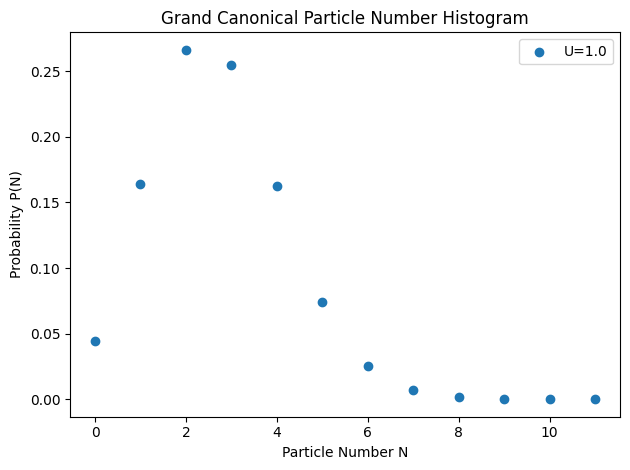

In [78]:
import glob

files = sorted(glob.glob("/Users/wmallah/Documents/GitHub/BH_Gutzwiller_VMC/VMCBoseHubbard/data/GC/1D/L4_N2/PN_hist_U*.dat"))

for file in files:
    print("FILE:", file)
    data = np.loadtxt(file, comments="#")
    if data.ndim == 1:
        data = data[None, :]  # handle single-line case

    N_vals = data[:, 0]
    counts = data[:, 1]
    counts /= counts.sum()  # Normalize

    U = file.split("U")[-1].split(".dat")[0]
    plt.scatter(N_vals, counts, label=f"U={U}")

plt.xlabel("Particle Number N")
plt.ylabel("Probability P(N)")
plt.title("Grand Canonical Particle Number Histogram")
plt.legend()
plt.tight_layout()
plt.show()

# Plot to Determine Range of $\mu$ Values for Two-Particle Ground State

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/var/folders/70/dpchvndd0rdgb5qvz1j_ks240000gn/T/ipykernel_91215/3018114201.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu$')


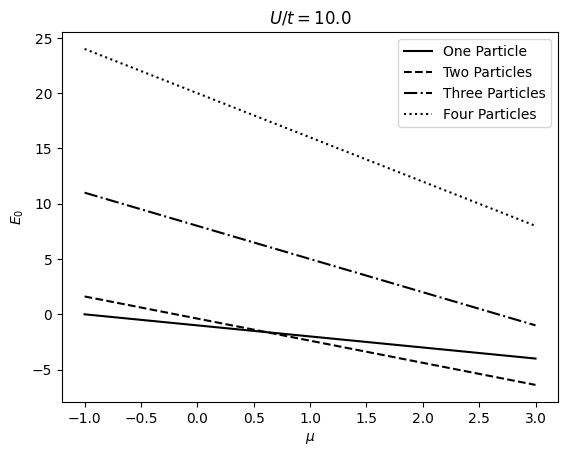

In [27]:
t = 1.0
U = 10.0

def one_particle_energy(t, mu):
    return -mu - t

def two_particle_energy(t, U, mu):
    return U / 2.0 - 2*mu - np.sqrt(U**2 + 16*t**2.0)/2.0

def three_particle_energy(t,U, mu):
    return -2*t + U - 3*mu

def four_particle_energy(t, U, mu):
    return 2*(U - 2*mu)

mu = np.linspace(-1.0, 3.0, 100)

plt.plot(mu, one_particle_energy(t,mu), c='k', linestyle='-', label='One Particle')
plt.plot(mu, two_particle_energy(t, U, mu), c='k', linestyle='--', label='Two Particles')
plt.plot(mu, three_particle_energy(t,U,mu), c='k', linestyle='-.', label='Three Particles')
plt.plot(mu, four_particle_energy(t,U,mu), c='k', linestyle=':', label='Four Particles')
plt.xlabel('$\mu$')
plt.ylabel('$E_0$')
plt.title('$U/t=10.0$')
plt.legend(loc='best')

# Exact Ground State Energy for 2 Particles on 2 Sites

In [50]:
U = 10.0
t = 1.0
mu = 4.2

print(1/2*(U - np.sqrt(16*t**2 + U**2) - 4*mu))

-8.785164807134503


In [70]:
import numpy as np
from itertools import product

def _fixed_N_fock_basis(L: int, N: int):
    """All occupation tuples (n0,...,n_{L-1}) with sum n_i = N."""
    basis = []
    for occ in product(range(N + 1), repeat=L):
        if sum(occ) == N:
            basis.append(tuple(occ))
    return basis

def bose_hubbard_ed_ground_state(L=4, N=2, t=1.0, U=10.0, mu=0.0, periodic=True,
                                return_state=False, return_basis=False):
    """
    Exact diagonalization (canonical, fixed N) for the 1D Bose–Hubbard model:

        H = -t * Σ_<i,j> (b_i† b_j + b_j† b_i)
            + (U/2) * Σ_i n_i (n_i - 1)
            - mu * Σ_i n_i

    For fixed N, the chemical potential term contributes a constant shift (-mu*N)
    to all eigenvalues, but we include it explicitly for consistency with your VMC.

    Parameters
    ----------
    L, N : int
        Number of sites and bosons.
    t, U, mu : float
        Hopping, interaction, chemical potential.
    periodic : bool
        Periodic boundary conditions if True; open chain if False.
    return_state : bool
        If True, return the ground-state eigenvector coefficients in the Fock basis.
    return_basis : bool
        If True, return the basis list of occupation tuples.

    Returns
    -------
    E0 : float
        Ground-state energy.
    (optional) psi0 : np.ndarray
        Ground-state eigenvector in the chosen basis ordering.
    (optional) basis : list[tuple[int,...]]
        Fock basis states.
    """
    basis = _fixed_N_fock_basis(L, N)
    dim = len(basis)
    idx = {s: k for k, s in enumerate(basis)}

    H = np.zeros((dim, dim), dtype=np.float64)

    # 1D nearest-neighbor bonds
    if periodic:
        bonds = [(i, (i + 1) % L) for i in range(L)]
    else:
        bonds = [(i, i + 1) for i in range(L - 1)]

    for a, state in enumerate(basis):
        n = np.array(state, dtype=int)

        # Diagonal: interaction + chemical potential
        H[a, a] += 0.5 * U * np.sum(n * (n - 1))          # (U/2) Σ n_i(n_i-1)
        H[a, a] += -mu * np.sum(n)                         # -mu Σ n_i  (=-mu*N)

        # Off-diagonal: hopping on each bond
        # -t (b_i† b_j + b_j† b_i)
        for i, j in bonds:
            # hop j -> i : b_i† b_j
            if n[j] > 0:
                n2 = n.copy()
                n2[i] += 1
                n2[j] -= 1
                b = idx[tuple(n2)]
                H[a, b] += -t * np.sqrt((n[i] + 1) * n[j])

            # hop i -> j : b_j† b_i
            if n[i] > 0:
                n2 = n.copy()
                n2[j] += 1
                n2[i] -= 1
                b = idx[tuple(n2)]
                H[a, b] += -t * np.sqrt((n[j] + 1) * n[i])

    # Sanity: should be symmetric (real Hermitian)
    if not np.allclose(H, H.T, atol=1e-12):
        raise RuntimeError("Hamiltonian is not symmetric; check construction.")

    evals, evecs = np.linalg.eigh(H)
    E0 = float(evals[0])

    out = (E0,)
    if return_state:
        out += (evecs[:, 0].copy(),)
    if return_basis:
        out += (basis,)
    return out[0] if len(out) == 1 else out

# ---- Example usage (edit to match your VMC parameters) ----
L, N = 4, 2
t, U, mu = 1.0, 1.0, -1.996641490650
E0, psi0, basis = bose_hubbard_ed_ground_state(L=L, N=N, t=t, U=U, mu=mu,
                                               periodic=True,
                                               return_state=True,
                                               return_basis=True)

print(f"L={L}, N={N}, t={t}, U={U}, mu={mu} (PBC)")
print(f"Ground-state energy E0 = {E0:.12f}")

# Optional: show the largest-amplitude Fock components
probs = np.abs(psi0)**2
order = np.argsort(probs)[::-1]
print("\nTop Fock components |n0 n1 n2 n3> with probabilities:")
for k in order[:5]:
    print(f"  {basis[k]} : {probs[k]:.6f}")


L=4, N=2, t=1.0, U=1.0, mu=-1.99664149065 (PBC)
Ground-state energy E0 = 0.208022116470

Top Fock components |n0 n1 n2 n3> with probabilities:
  (1, 0, 1, 0) : 0.146338
  (0, 1, 0, 1) : 0.146338
  (0, 1, 1, 0) : 0.131048
  (1, 1, 0, 0) : 0.131048
  (0, 0, 1, 1) : 0.131048
